
KMeans Results:
Number of Clusters: 3
Silhouette Score: 0.217

Hierarchical Results:
Number of Clusters: 3
Silhouette Score: 0.225

DBSCAN Parameter Search Results:
    eps  min_samples  n_clusters  n_noise  sil_score
10  2.0           10           2      106   0.197070
11  2.0           15           2      123   0.182558
9   2.0            5           3       87   0.131261
6   1.5            5           4      258  -0.034967
7   1.5           10           2      352  -0.057138

Best DBSCAN Parameters: eps=2.0, min_samples=10
Number of Clusters: 2
Number of Noise Points: 106
Silhouette Score: 0.197


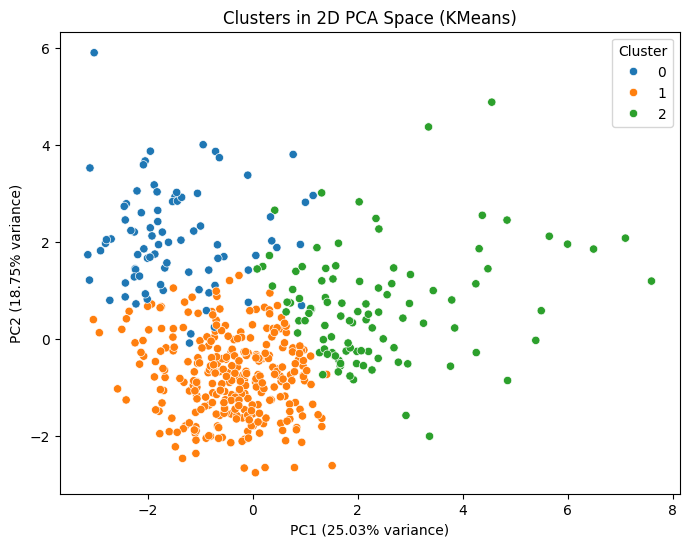

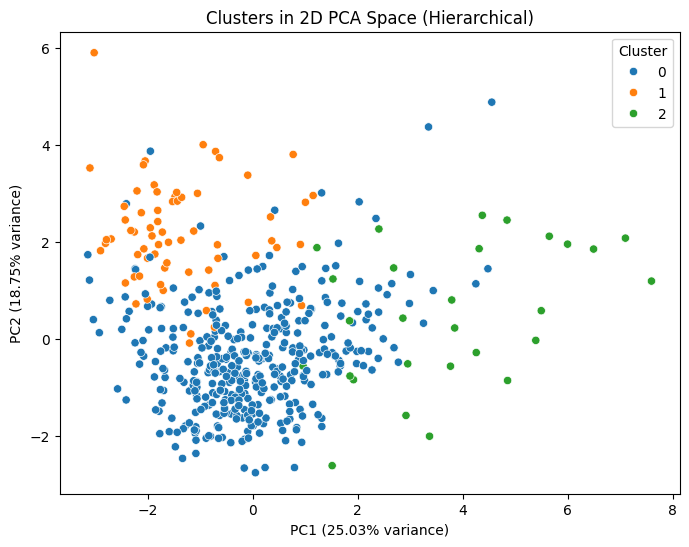

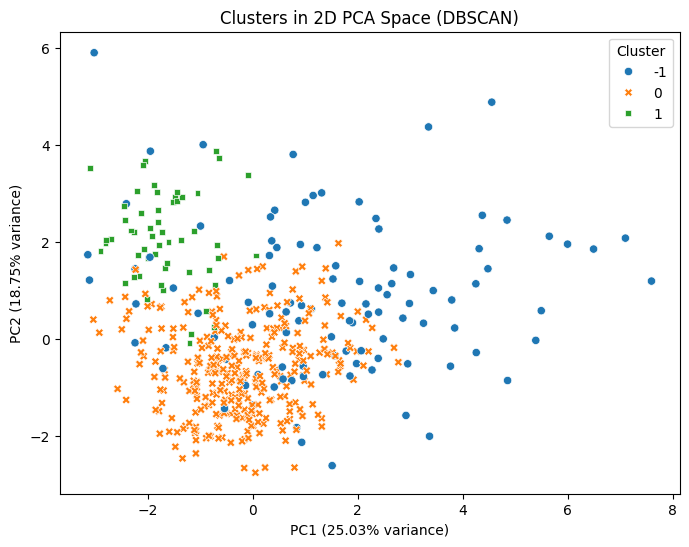


KMeans Cluster Interpretation:
Cluster Centroids (Mean Feature Values):
                 median_volatility  hist_volatility  mean_momentum  \
Cluster_KMeans                                                      
0                        0.017226         0.243153       1.010241   
1                        0.017106         0.240699       1.004782   
2                        0.026952         0.411895       1.001874   

                mean_volume_norm  environmentScore  socialScore  \
Cluster_KMeans                                                    
0                       0.000081          1.707561    10.038537   
1                       0.000075          6.894433     8.754500   
2                       0.000285          6.500000     9.368911   

                governanceScore  marketCap      beta  highestControversy  \
Cluster_KMeans                                                             
0                      8.745000  24.945307  1.041390            1.853659   
1               

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Load dataset
data = pd.read_csv('merged_data.csv')

# Step 1: Preprocessing
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data = data.dropna(subset=['GICS Sector'])
for col in ['environmentScore', 'socialScore', 'governanceScore', 'marketCap', 'beta', 'highestControversy']:
    data[col].fillna(data[col].median(), inplace=True)

# Step 2: Feature Engineering
# Intraday volatility
data['volatility'] = (data['High'] - data['Low']) / data['Open']

# Rolling features per ticker
def compute_rolling_features(group):
    group = group.sort_values('Date')
    group['returns'] = group['Close'].pct_change()
    group['hist_volatility'] = group['returns'].std() * np.sqrt(252)  # Annualized
    group['ma10'] = group['Close'].rolling(window=10, min_periods=5).mean()
    group['ma30'] = group['Close'].rolling(window=30, min_periods=10).mean()
    group['momentum'] = group['ma10'] / group['ma30']
    group['volume_norm'] = group['Volume'] / group['marketCap']
    return group

data = data.groupby('Symbol').apply(compute_rolling_features).reset_index(drop=True)

# Aggregate by Symbol
def compute_features(group):
    return pd.Series({
        'median_volatility': group['volatility'].median(),
        'hist_volatility': group['hist_volatility'].mean(),
        'mean_momentum': group['momentum'].mean(),
        'mean_volume_norm': group['volume_norm'].mean(),
        'environmentScore': group['environmentScore'].iloc[0],
        'socialScore': group['socialScore'].iloc[0],
        'governanceScore': group['governanceScore'].iloc[0],
        'marketCap': np.log1p(group['marketCap'].iloc[0]),  # Log-transform
        'beta': group['beta'].iloc[0],
        'highestControversy': group['highestControversy'].iloc[0],
        'GICS_Sector': group['GICS Sector'].iloc[0]
    })

agg_data = data.groupby('Symbol').apply(compute_features).reset_index()
agg_data = agg_data.dropna()

# Target encoding for GICS Sector (mean governanceScore)
agg_data['GICS_Sector_encoded'] = agg_data['GICS_Sector'].map(
    agg_data.groupby('GICS_Sector')['governanceScore'].mean()
)

# Step 3: Features for Clustering
features = [
    'median_volatility', 'hist_volatility', 'mean_momentum', 'mean_volume_norm',
    'environmentScore', 'socialScore', 'governanceScore', 'marketCap', 'beta',
    'highestControversy', 'GICS_Sector_encoded'
]
X = agg_data[features]

# Step 4: Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features)
    ])
X_scaled = preprocessor.fit_transform(X)

# Step 5: Clustering Methods
methods = {
    'KMeans': {'model': KMeans(n_clusters=3, random_state=42), 'labels': None},
    'Hierarchical': {'model': AgglomerativeClustering(n_clusters=3), 'labels': None},
    'DBSCAN': {'model': None, 'labels': None}  # DBSCAN requires tuning
}

# K-Means and Hierarchical Clustering
for method in ['KMeans', 'Hierarchical']:
    model = methods[method]['model']
    methods[method]['labels'] = model.fit_predict(X_scaled)
    methods[method]['sil_score'] = silhouette_score(X_scaled, methods[method]['labels'])
    print(f"\n{method} Results:")
    print(f"Number of Clusters: 3")
    print(f"Silhouette Score: {methods[method]['sil_score']:.3f}")

# DBSCAN Clustering with Grid Search
eps_range = np.arange(0.5, 2.1, 0.5)
min_samples_range = [5, 10, 15]
best_eps = 0
best_min_samples = 0
best_sil_score = -1
results = []

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        if n_clusters > 1:
            sil_score = silhouette_score(X_scaled, labels)
        else:
            sil_score = -1
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'sil_score': sil_score
        })
        if sil_score > best_sil_score:
            best_sil_score = sil_score
            best_eps = eps
            best_min_samples = min_samples
            methods['DBSCAN']['labels'] = labels

# Fit final DBSCAN model
methods['DBSCAN']['model'] = DBSCAN(eps=best_eps, min_samples=best_min_samples)
methods['DBSCAN']['labels'] = methods['DBSCAN']['model'].fit_predict(X_scaled)
methods['DBSCAN']['sil_score'] = best_sil_score
n_clusters_dbscan = len(set(methods['DBSCAN']['labels'])) - (1 if -1 in methods['DBSCAN']['labels'] else 0)
n_noise_dbscan = list(methods['DBSCAN']['labels']).count(-1)

print("\nDBSCAN Parameter Search Results:")
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='sil_score', ascending=False).head())
print(f"\nBest DBSCAN Parameters: eps={best_eps}, min_samples={best_min_samples}")
print(f"Number of Clusters: {n_clusters_dbscan}")
print(f"Number of Noise Points: {n_noise_dbscan}")
if n_clusters_dbscan > 1:
    print(f"Silhouette Score: {best_sil_score:.3f}")

# Step 6: Visualization (PCA for each method)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

for method in methods:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=X_pca[:, 0], y=X_pca[:, 1],
        hue=methods[method]['labels'], palette='tab10',
        style=methods[method]['labels'] if method == 'DBSCAN' else None
    )
    plt.title(f'Clusters in 2D PCA Space ({method})')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend(title='Cluster', loc='best')
    plt.show()

# Step 7: Interpret Clusters
for method in methods:
    print(f"\n{method} Cluster Interpretation:")
    agg_data[f'Cluster_{method}'] = methods[method]['labels']
    
    # Centroids (exclude noise for DBSCAN)
    if method == 'DBSCAN':
        cluster_summary = agg_data[agg_data[f'Cluster_{method}'] != -1].groupby(f'Cluster_{method}')[features].mean()
    else:
        cluster_summary = agg_data.groupby(f'Cluster_{method}')[features].mean()
    print("Cluster Centroids (Mean Feature Values):\n", cluster_summary)

    # Sector distribution (exclude noise for DBSCAN)
    if method == 'DBSCAN':
        sector_dist = agg_data[agg_data[f'Cluster_{method}'] != -1].groupby([f'Cluster_{method}', 'GICS_Sector']).size().unstack(fill_value=0)
    else:
        sector_dist = agg_data.groupby([f'Cluster_{method}', 'GICS_Sector']).size().unstack(fill_value=0)
    print("\nSector Distribution per Cluster:\n", sector_dist)

    # Example companies
    print("\nExample Companies per Cluster:")
    for cluster in sorted(set(agg_data[f'Cluster_{method}'])):
        if method == 'DBSCAN' and cluster == -1:
            print("Noise Points:", agg_data[agg_data[f'Cluster_{method}'] == -1]['Symbol'].head(5).tolist())
        else:
            companies = agg_data[agg_data[f'Cluster_{method}'] == cluster]['Symbol'].head(5).tolist()
            print(f"Cluster {cluster}: {companies}")

# Step 8: Save Results
for method in methods:
    output_data = agg_data[['Symbol'] + features + ['GICS_Sector', f'Cluster_{method}']]
    output_data.to_csv(f'clustered_companies__{method.lower()}.csv', index=False)
    print(f"\nClustered data saved as 'clustered_companies_{method.lower()}.csv'")